In [1]:
import sys
import subprocess
import requests
import cixcerts
from cdf.auth import get_iam_token
import getpass
import pandas as pd
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors,Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import *
from rdkit.Chem import SDWriter
import json
import numpy as np
from IPython.core.display import HTML

In [2]:
IPythonConsole.ipython_useSVG = True

In [3]:
def result_to_dataframe(json_result: str) -> pd.DataFrame:
    """ Converts JSON output to pd.DataFrame """
    records = []
    for entry in json_result["result"]:
        buildingblock = entry["BuildingBlock"]
        for variant in buildingblock["Variants"]:
            row = {
                **{k:v for (k,v) in buildingblock.items() if k != "Variants"},
                **variant
            }
            records.append(row)
    # results
    df = pd.DataFrame.from_records(records)
    return df

In [4]:
class ClientConfig:
    def __init__(
        self,
        username: str,
        password: str
    ):
        self.token = get_iam_token(
            user=username,
            password=password
        )
        self.cert = cixcerts.pem
        self.proxies = {
            "http": "http://nibr-proxy.global.nibr.novartis.net:2011",
            "https": "http://nibr-proxy.global.nibr.novartis.net:2011"
        }
        self.base_url = "https://daid-building-blocks.dev.nibr.novartis.net"
        
        self.headers = {
            "Content-Type": "application/json",
            "accept": "application/json"
        }
        
class Client:
    def __init__(
        self,
        config: ClientConfig,
    ):
        self.config = config
        
    def search(self, json_query) -> str:
        url = f"{self.config.base_url}/api/building_block/search"
        
        try:
            r = requests.post(
                url, 
                json=json_query, 
                #proxies=self.config.proxies, 
                verify=None,#self.config.cert,
                #headers=self.config.headers,
                cookies={
                    "ObSSOCookie": self.config.token,
                },
            )
            r.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print(e.response.text)
            raise(e)
        return r.json()

In [5]:
from rdkit.Chem.FilterCatalog import *
functional_groups = GetFlattenedFunctionalGroupHierarchy()

In [6]:
def count_components(mol):
    ctr = 0
    mol_frags = AllChem.GetMolFrags(mol)
    for frag in mol_frags:
        ctr += 1
    return ctr

def count_functional_group(mol, functional_group):
    ctr = 0
    for match in mol.GetSubstructMatches(functional_group):
        ctr += 1
    return ctr

def boolean_to_int(inputvalue):
    if (inputvalue == True):
        return 1
    return 0

In [7]:
def get_rd_smi(smile):
    mol=Chem.MolFromSmiles(smile)
    return Chem.MolToSmiles(mol)

In [8]:
def get_mw(mol):
    return rdMolDescriptors.CalcExactMolWt(mol)

In [9]:
def get_clogp(mol):
    return float(Descriptors.MolLogP(mol))

In [10]:
def ring_count(mol):
    return rdMolDescriptors.CalcNumRings(mol)

In [11]:
def get_tpsa(mol):
    return rdMolDescriptors.CalcTPSA(mol)

In [12]:
def get_HBD(mol):
    return rdMolDescriptors.CalcNumHBD(mol)

In [13]:
def get_HBA(mol):
    return rdMolDescriptors.CalcNumHBA(mol)

In [14]:
def get_rotbond(mol):
    return rdMolDescriptors.CalcNumRotatableBonds(mol)

In [15]:
def FusedRingCount(mol):
    RingFusedAtom=AllChem.MolFromSmarts('[*R2]')
    matches=mol.GetSubstructMatches(RingFusedAtom)
    return int(len(matches)/2)

In [16]:
def frac_sp3(mol):
    return rdMolDescriptors.CalcFractionCSP3(mol)

In [17]:
functional_groups['amidine'] = AllChem.MolFromSmarts('[NX3][CX3](=[NX1])')
functional_groups['amide.primary'] = AllChem.MolFromSmarts('[NX3;H2][CX3](=[OX1])[#6]')
functional_groups['amide.secondary'] = AllChem.MolFromSmarts('[#6][NX3;H1][CX3](=[OX1])[#6]')
functional_groups['amide.tertiary'] = AllChem.MolFromSmarts('[#6][NX3;H0]([#6])[CX3](=[OX1])[#6]')
functional_groups['aniline'] = AllChem.MolFromSmarts('[NX3][$(cc)]')
functional_groups['aniline.primary'] = AllChem.MolFromSmarts('[NX3;H2][$(cc)]')
functional_groups['aniline.secondary'] = AllChem.MolFromSmarts('[NX3;H][$(cc)]')
functional_groups['anhydride'] = AllChem.MolFromSmarts('CC(CC(C)=O)=O')
functional_groups['azo'] = AllChem.MolFromSmarts('[NX2]=[NX2]')
functional_groups['bromine'] = AllChem.MolFromSmarts('[Br]')
functional_groups['bromine.aromatic'] = AllChem.MolFromSmarts('[Br]a')
functional_groups['disulfide'] = AllChem.MolFromSmarts('[#16X2][#16X2]')
functional_groups['enamime'] = AllChem.MolFromSmarts('[NX3][$(C=C)]')
functional_groups['hydrazine'] = AllChem.MolFromSmarts('[NX3][NX3]')
functional_groups['hydroxylamine'] = AllChem.MolFromSmarts('[N;H1][O]')
functional_groups['iodine'] = AllChem.MolFromSmarts('[I]')
functional_groups['phosphorus'] = AllChem.MolFromSmarts('[P]')
functional_groups['silicon'] = AllChem.MolFromSmarts('[Si]')
functional_groups['sulfonamide'] = AllChem.MolFromSmarts('[N]-[S]')
functional_groups['sulfonicacid'] = AllChem.MolFromSmarts('[O;H][S](=O)(=O)')
functional_groups['thioketone'] = AllChem.MolFromSmarts('[#6][CX3](=S)[#6]')
functional_groups['thiol'] = AllChem.MolFromSmarts('[#16X2H]')
functional_groups['hydroxy.aliphatic'] = AllChem.MolFromSmarts('[OX2;H1][CX4]')
functional_groups['hydroxy.aromatic'] = AllChem.MolFromSmarts('[OX2;H1]c')
functional_groups['chloro.sp3'] = AllChem.MolFromSmarts('[Cl]-C')
functional_groups['chloro.sp2'] = AllChem.MolFromSmarts('[Cl]-[$([cX3](:*):*),$([cX2+](:*):*),$([CX3]=*),$([CX2+]=*)]')
functional_groups['het.carbon.het'] =  AllChem.MolFromSmarts('[A]-[N,O,S]-[CX4]-[N,O,S]-[A]')
functional_groups['nitrogen-halogen'] = AllChem.MolFromSmarts('[#7]-[F,Cl,Br,I]')
functional_groups['S-S'] = AllChem.MolFromSmarts('[#16]-[#16]')

# these are for exclusions
functional_groups['sodium'] = AllChem.MolFromSmarts('[Na]')
functional_groups['arsenic'] = AllChem.MolFromSmarts('[As]')
functional_groups['selenium'] = AllChem.MolFromSmarts('[Se]')

functional_groups['ester'] = AllChem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]')
functional_groups['ketone'] = AllChem.MolFromSmarts('[#6][CX3](=[OX1])[#6]')

functional_groups['epoxide'] = AllChem.MolFromSmarts('[#6]-1-[#6]-[#8]-1')

functional_groups['alcohol.primary'] = AllChem.MolFromSmarts('[#6][CH2][OH]')
functional_groups['alcohol.secondary'] = AllChem.MolFromSmarts('[#6][CH]([#6])[OH]')
functional_groups['alcohol.tertiary'] = AllChem.MolFromSmarts('[#6][C]([#6])([#6])[OH]')
functional_groups['alcohol.phenol'] = AllChem.MolFromSmarts('c[OH]')

functional_groups['alkene']=AllChem.MolFromSmarts('[C]=[C]')
functional_groups['terminal_alkene']=AllChem.MolFromSmarts('[C]=[C;H2]')
functional_groups['alkyne']=AllChem.MolFromSmarts('C#C')

functional_groups['NCO2H']=AllChem.MolFromSmarts('[#7]-[CX3](-[#8;H1])=O')
functional_groups['sulfonylfluoride']=AllChem.MolFromSmarts('[$(S-&!@[#6])](=O)(=O)-,:F')
functional_groups['methylamino_acrylate']=AllChem.MolFromSmarts('[CX4]-[#8]-[CX3](=O)\\[#6&X3]=[#6&X3]\\[N]')
functional_groups['acetal']=AllChem.MolFromSmarts('[#8X2]-[CX4]-[#8X2]')
functional_groups['cyanamido']=AllChem.MolFromSmarts('[N]C#N')

functional_groups['tBOC'] = AllChem.MolFromSmarts('[CH3]C([CH3])([CH3])[#8]-[#6](-[#7])=O')

functional_groups['Nitrile'] = AllChem.MolFromSmarts('[CX2]#[NX1]')

functional_groups['diazarine'] = AllChem.MolFromSmarts('[#7]~1~[#7]~[#6]~1')
functional_groups['aziridine'] = AllChem.MolFromSmarts('[#7]-1-[#6]-[#6]-1')
functional_groups['acrylamide'] = AllChem.MolFromSmarts('[#7]-[#6](=[O])-[#6]=[#6]')
functional_groups['acyl_chloride'] = AllChem.MolFromSmarts('[#6](=[O])-[Cl]')
functional_groups['deuterium'] = AllChem.MolFromSmarts('[2#1]')
functional_groups['tritium'] = AllChem.MolFromSmarts('[3#1]')
functional_groups['NO'] = AllChem.MolFromSmarts('[N]-[O]')
functional_groups['C11'] = AllChem.MolFromSmarts('[11#6]')
functional_groups['C13'] = AllChem.MolFromSmarts('[13#6]')
functional_groups['CSOC'] = AllChem.MolFromSmarts('[#6]-[S,O1]([O])-[#6]')
functional_groups['thioamide'] = AllChem.MolFromSmarts('[N][CX3](=[SX1])[#6]')
functional_groups['thiolate'] = AllChem.MolFromSmarts('[SH]')

functional_groups['Amine.Secondary.Ring'] = AllChem.MolFromSmarts('[N&R&H1&D2&$(N(-[CH2;R])-[CH2;R])&!$(N-C=[O,N,S])]')
functional_groups['Amine.Secondary.CH3'] = AllChem.MolFromSmarts('[N&H1&D2&$(N(-[CH3;R0])-[C;R])&!$(N-C=[O,N,S])]')
functional_groups['Amine.Primary.H'] = AllChem.MolFromSmarts('[N&R0&H2&D1&$(N-&!@C)&$(N-[C;R])&!$(N-C=[O,N,S])]')

#functional_groups['tBOC'] = AllChem.MolFromSmarts('[CH3]C([CH3])([CH3])[#8]-[#6](-[N&D3&$(N(-[#6])(-[#6])-[#6])])=O')
#functional_groups['Fmoc'] = AllChem.MolFromSmarts('[N&D3&$(N(-[#6])(-[#6])-[#6])]-[#6](=O)-[#8]-[#6]-[#6]~1~[#6]~2~[#6](~[c;H1]~[c;H1]~[c;H1]~[c;H1]~2)~[#6]~2~[#6]~1~[c;H1]~[c;H1]~[c;H1]~[c;H1]~2')
#functional_groups['CBz'] = AllChem.MolFromSmarts('[N&D3&$(N(-[#6])(-[#6])-[#6])]-[#6](=O)-[#8]-[C;H2]-[c]~1~[c;H1]~[c;H1]~[c;H1]~[c;H1]~[c;H1]~1')

# reaction to deprotect tBOC
# deprotect_rxn_string = "[N:1]C(=O)OC([CH3])([CH3])([CH3])>>[N:1]"

In [18]:
def set_query(smarts_str):
    
    json_query = {
    "search": {
        "kind": "smarts",
        "attribute": "atdb",
        "value": smarts_str,
        "operator": "equals",
    },
    "limit": 10000000,
    "offset": 0
    }
    
    return json_query

In [19]:
# example to limit catalogue and amount
'''
def set_query(smarts_str):
    
    json_query = {
    "limit": 10000000,
    "offset": 0,
    "search": {
    "operation": "and_",
    "filters":[
        {
        "kind": "smarts",
        "attribute": "atdb",
        "value": smarts_str,
        "operator": "equals",
        },
        {
        "kind":"logistic",
        "attribute": "catalogue",
        "value": "Enamine - PFL Library Building-Block",
        "operator": "equals",
                },
        {
        "kind":"logistic",
        "attribute": "amount",
        "value": 0,
        "operator": "gt",
                },
            ]
        }
    }
    return json_query
'''

'\ndef set_query(smarts_str):\n    \n    json_query = {\n    "limit": 10000000,\n    "offset": 0,\n    "search": {\n    "operation": "and_",\n    "filters":[\n        {\n        "kind": "smarts",\n        "attribute": "atdb",\n        "value": smarts_str,\n        "operator": "equals",\n        },\n        {\n        "kind":"logistic",\n        "attribute": "catalogue",\n        "value": "Enamine - PFL Library Building-Block",\n        "operator": "equals",\n                },\n        {\n        "kind":"logistic",\n        "attribute": "amount",\n        "value": 0,\n        "operator": "gt",\n                },\n            ]\n        }\n    }\n    return json_query\n'

# Uncomment and add your credentials

In [20]:
user = input('Username: ')

Username: dicksca3


In [21]:
pw = getpass.getpass('Password: ')

Password: ········


In [22]:
config = ClientConfig(username=user, password=pw)
client = Client(config)

In [23]:
AllChem.MolToSmarts(functional_groups['Amine.Secondary'])

'[N&H1&D2&$(N(-[#6])-[#6])&!$(N-C=[O,N,S])]'

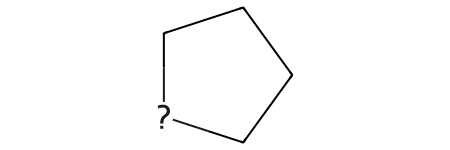

In [24]:
AllChem.MolFromSmarts('[#6]-1-[#6]-[#6]-[N&H1&D2&$(N(-[#6])-[#6])&!$(N-C=[O,N,S])]-[#6]-1')

In [25]:
# smarts query: pyrrolidine
pyrrolidine = "[#6]-1-[#6]-[#6]-[N&H1&D2&$(N(-[#6])-[#6])&!$(N-C=[O,N,S])]-[#6]-1"

# Query for building block reagents via SMARTS pattern

In [26]:
result = client.search(set_query(pyrrolidine))
df=result_to_dataframe(result)

In [27]:
len(df)

130045

In [28]:
list(df.columns)

['smiles',
 'id',
 'catalogue',
 'vendor',
 'location',
 'order_information',
 'system',
 'site',
 'amount',
 'amount_unit',
 'concentration',
 'concentration_unit',
 'salt']

### Next steps put dataframe into easier format, personal preference

In [29]:
set(list(df['site']))

{'CHBS', 'EXT', 'SDUS', 'USCA', 'USEM', 'USLJ'}

In [30]:
df['site_generic'] = np.where(df['site'].str.lower()=='ext', 'External', 'NIBR')

In [31]:
# put internal BBs first
df=df.sort_values(by=['site_generic'],ascending=[False])

In [34]:
df=df.dropna(subset=['smiles'])

In [35]:
df=df.drop_duplicates(subset=['smiles'])
df=df.reset_index(drop=True)

In [36]:
df.head()

,smiles,id,catalogue,vendor,location,order_information,system,site,amount,amount_unit,concentration,concentration_unit,salt,site_generic
0,COc1cc(-c2cn(C)c(=O)c3cnccc23)c(OC)cc1CNC1CC2C...,3430244967101118986,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,34269718,SMF,CHBS,4.1,mg,NaN,None,False,NIBR
1,CC1(C)CC(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(N)c34)c(C...,3687459858955306403,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,36205882,SMF,CHBS,47.4,mg,NaN,None,False,NIBR
2,Cc1ccc(Oc2nc3ncccc3s2)cc1C1CCCN1,7867111960124963586,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,26362458,SMF,CHBS,99.3,mg,NaN,None,False,NIBR
3,CCOC(=O)C1(c2ccccc2)CNC(C)C1,1941952249155836829,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,12362028,SMF,CHBS,162.8,mg,NaN,None,False,NIBR
4,Cc1ccc(OC2CNCC2O)cc1C,6612777133414317983,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,81899944,SMF,CHBS,380.0,mg,NaN,None,False,NIBR


# Define the scaffold to react with

In [37]:
scaffold = AllChem.MolFromSmiles('NC1=CC(C2CC2)=C(N=C1OC3=CN=CC(C(O)=O)=C3CC)C4=C5C(C)=NNC5=CC(F)=C4Cl')

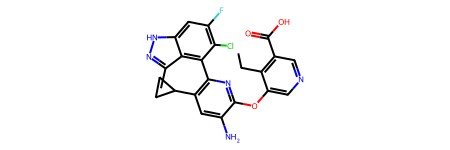

In [38]:
scaffold

In [39]:
df=df.reset_index(drop=True)

In [40]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles','BB_ROMol')

In [41]:
df=df.dropna(subset=['BB_ROMol'])

In [42]:
df['mw']=df['BB_ROMol'].apply(get_mw)

In [43]:
# quick filter by MW
df=df[df['mw']<450]

In [44]:
df=df.drop(columns=['mw'])

In [45]:
df=df.reset_index(drop=True)

## Count functional groups present in building blocks

In [46]:
for functional_group in sorted(functional_groups.keys(), key=lambda x:x.lower()):
       df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))

/tmp/ipykernel_25703/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))
/tmp/ipykernel_25703/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))
/tmp/ipykernel_25703/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is 

## Can filter building blocks by presence of functional groups

In [47]:
df=df[df['count_Amine']<2]

In [48]:
# Remove some more groups
df=df[df['count_Aldehyde']==0]
df=df[df['count_Azide']==0]
df=df[df['count_NCO2H']==0]
df=df[df['count_BoronicAcid']==0]
df=df[df['count_hydrazine']==0]
df=df[df['count_Nitro']==0]
df=df[df['count_Isocyanate']==0]
df=df[df['count_phosphorus']==0]
df=df[df['count_silicon']==0]
df=df[df['count_arsenic']==0]
df=df[df['count_sodium']==0]
df=df[df['count_selenium']==0]
df=df[df['count_S-S']==0]


In [49]:
df=df.reset_index(drop=True)

## This next section reacts the building blocks with the scaffold of interest.

### Define the Reaction SMARTS to perform a simple amide-coupling.

In [50]:
rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])[OH].[N;!$(N-c);$(N-C);!$(N-[!#6;!#1]);!$(N-C=[O,N,S]):3]>>[C:1](=[O:2])[N:3]')

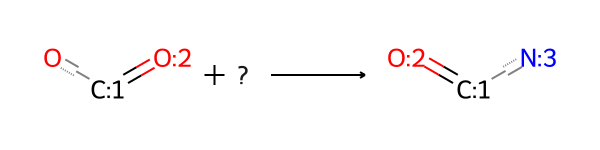

In [51]:
rxn

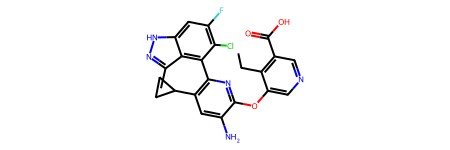

In [52]:
scaffold

# Run the enumeration

In [53]:
df['PRODUCT_SMILES']=None
for index, row in df.iterrows():
    
    bb_mol=row['BB_ROMol']
    
    try:
        cur_product=rxn.RunReactants((scaffold, bb_mol))[0][0]

        cur_smi=AllChem.MolToSmiles(cur_product, canonical=True, isomericSmiles=True)
    
        df.at[index,'PRODUCT_SMILES']=cur_smi
    except:
        print(row['smiles'])
        df.at[index,'PRODUCT_SMILES']='FAILED'

In [54]:
# drop failed reactions
df.drop(df.loc[df['PRODUCT_SMILES']=='FAILED'].index, inplace=True)

In [55]:
# drop duplicates
df.drop_duplicates(keep='first', subset='PRODUCT_SMILES', inplace=True)

In [56]:
df=df.reset_index(drop=True)

In [57]:
len(df)

32172

## tBOC deprotections, final molecule save in "PRODUCT_FINAL"

In [58]:
# up to 2 tBOC deprotections per mol
df['PRODUCT_FINAL']=None
df['Deprotected']=None

deprotect_rxn = AllChem.ReactionFromSmarts("[#7:1]C(=O)OC([CH3])([CH3])([CH3])>>[#7:1][H]")

for index, row in df.iterrows():
    if int(row['count_tBOC'])==0:
        df.at[index,'PRODUCT_FINAL']=row['PRODUCT_SMILES']
        df.at[index,'Deprotected']=0

    elif int(row['count_tBOC'])>0:
        try:
            deprotect_mol=deprotect_rxn.RunReactants((AllChem.MolFromSmiles(row['PRODUCT_SMILES']),))[0][0]
            deprotect_mol=AllChem.RemoveHs(deprotect_mol)
            deprotect_smi=AllChem.MolToSmiles(deprotect_mol)
            
            if int(row['count_tBOC'])==2:
                sec_deprotect=deprotect_rxn.RunReactants((deprotect_mol,))[0][0]
                deprotect_mol=AllChem.RemoveHs(sec_deprotect)
                deprotect_smi=AllChem.MolToSmiles(deprotect_mol)
        
            df.at[index,'PRODUCT_FINAL']=deprotect_smi
            df.at[index,'Deprotected']=1
        except:
            print(row['PRODUCT_SMILES'])

In [59]:
df.drop_duplicates(keep='first', subset='PRODUCT_FINAL', inplace=True)

In [60]:
df=df.reset_index(drop=True)

In [61]:
df.head()

,smiles,id,catalogue,vendor,location,order_information,system,site,amount,amount_unit,...,count_SulfonylChloride.Aromatic,count_sulfonylfluoride,count_tBOC,count_terminal_alkene,count_TerminalAlkyne,count_thioketone,count_thiol,PRODUCT_SMILES,PRODUCT_FINAL,Deprotected
0,Cc1ccc(Oc2nc3ncccc3s2)cc1C1CCCN1,7867111960124963586,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,26362458,SMF,CHBS,99.30,mg,...,0,0,0,0,0,0,0,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,0
1,CCOC(=O)C1(c2ccccc2)CNC(C)C1,1941952249155836829,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,12362028,SMF,CHBS,162.80,mg,...,0,0,0,0,0,0,0,CCOC(=O)C1(c2ccccc2)CC(C)N(C(=O)c2cncc(Oc3nc(-...,CCOC(=O)C1(c2ccccc2)CC(C)N(C(=O)c2cncc(Oc3nc(-...,0
2,Cc1ccc(OC2CNCC2O)cc1C,6612777133414317983,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,81899944,SMF,CHBS,380.00,mg,...,0,0,0,0,0,0,0,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,0
3,COC(=O)C[C@@H]1CCCN1,7947856337759612732,Stockroom Chemicals Chemstore,ABCR,CH_WSJ-BANTING 1.P.Stockroom (Banting 1),00279898,CHEMSTORE,CHBS,0.60,g,...,0,0,0,0,0,0,0,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,0
4,O=C(Cc1ccc2[nH]ccc2c1)NC1CNCC1c1ccc(C(F)(F)F)cc1,3099608333163300655,Novartis Compound HUB Powders,Novartis,Powder Store 2 San Diego,J0566398,SMF,SDUS,2.93,mg,...,0,0,0,0,0,0,0,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,CCc1c(Oc2nc(-c3c(Cl)c(F)cc4[nH]nc(C)c34)c(C3CC...,0


### first BB

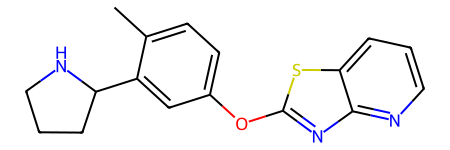

In [62]:
AllChem.MolFromSmiles(df.loc[0,'smiles'])

### first product

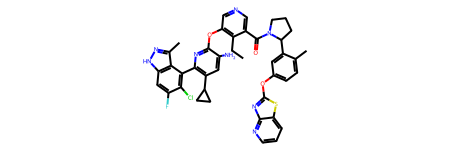

In [63]:
AllChem.MolFromSmiles(df.loc[0,'PRODUCT_FINAL'])

In [64]:
df.drop(columns=['BB_ROMol']).to_csv('enumeration_output.csv',index=False)